[View in Colaboratory](https://colab.research.google.com/github/aescherling/digit-recognizer/blob/master/digit_recognizer_victorem.ipynb)

# Digit recognizer - Victor Em

### Initial setup

In [1]:
#Sourced from https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
!pip install kaggle

    100% |████████████████████████████████| 61kB 4.0MB/s 
    100% |████████████████████████████████| 235kB 7.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [15]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

IndexError: ignored

In [20]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Colab Notebooks"

'Copy of digit-recognizer-victorem.ipynb'   test.csv
 digit-recognizer-victorem.ipynb	    train.csv
 sample_submission.csv			    Untitled0.ipynb


In [0]:
# load necessary libraries
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt

In [0]:
# load the data
train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")

### Taking a look at the data

In [26]:
# take a peek
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


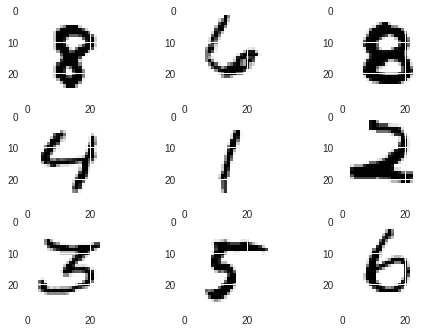

In [27]:
# plot a few digits.
# copied this code from https://www.kaggle.com/uysimty/digit-recognize-with-sklearn
def show_image(train_image, index):
    image_shaped = train_image.values.reshape(28,28)
    plt.subplot(3, 3, index+1)
    plt.imshow(image_shaped)

images_pixels = train_data.drop(columns=['label'])
sample_image = images_pixels.sample(9).reset_index(drop=True)
for index, image_pixels in sample_image.iterrows():
    show_image(image_pixels, index)

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [33]:
#Potential new feature considered, a sum of all rows
train_data['sum_of_all_rows'] = train_data.sum(axis=1) - train_data['label']
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,sum_of_all_rows
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16649
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44609
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13425
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15025
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,51093


In [37]:
#Data Exploration - Examine the sum_of_all_rows grouped by label
print(train_data['sum_of_all_rows'].describe())

count    42000.000000
mean     26192.586357
std       8689.173890
min       5086.000000
25%      19908.750000
50%      25567.000000
75%      31645.250000
max      79483.000000
Name: sum_of_all_rows, dtype: float64

In [41]:
train_data_small = train_data[['label', 'sum_of_all_rows']]
train_data_small.groupby(['label']).describe()

sum_of_all_rows                                                         \
                count          mean          std      min       25%      50%   
label                                                                          
0              4132.0  34632.407551  8462.916175  11994.0  28625.75  34125.0   
1              4684.0  15188.466268  4409.932467   5086.0  11969.50  14667.0   
2              4177.0  29871.099354  7653.922452   9033.0  24319.00  29474.0   
3              4351.0  28320.188003  7574.975072   8102.0  22895.00  27772.0   
4              4072.0  24232.722495  6375.416341   8238.0  19566.00  23557.0   
5              3795.0  25835.920422  7527.594832   7753.0  20383.50  25150.0   
6              4137.0  27734.917331  7531.413493   6593.0  22332.00  27124.0   
7              4401.0  22931.244263  6169.041786   8801.0  18423.00  22260.0   
8              4063.0  30184.148413  7778.353634  10358.0  24724.00  29454.0   
9              4188.0  24553.750000  6466.003344   8884.0  20048.75  23867.0   

                          
            75%      max  
label                     
0      39834.25  79483.0  
1      17717.25  43682.0  
2      34831.00  65413.0  
3      33310.50  60306.0  
4      28225.50  53832.0  
5      30419.50  59791.0  
6      32464.00  62494.0  
7      26668.00  52339.0  
8      34855.00  62762.0  
9      28304.75  54830.0

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


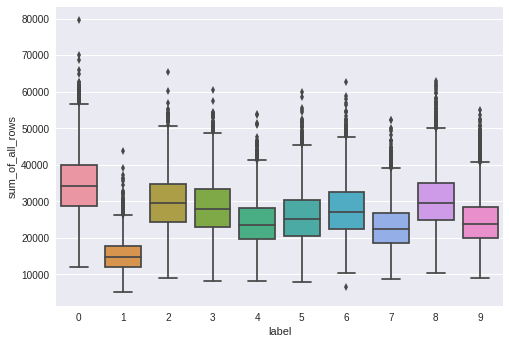

In [42]:
import seaborn as sns
sns.boxplot(x='label', y='sum_of_all_rows', data=train_data_small)

In [45]:
#position of each pixel, intensity of each pixel, column means of the training data
#roughtly half of the pixels are normally 0 to 10 in terms of intensity
#bimodal distribution, tiny peak around an intensity of 20 and 90
#total intensity

count    42000.000000
mean        73.575262
std        104.181414
min          0.000000
25%          0.000000
50%          0.000000
75%        180.000000
max        255.000000
Name: pixel400, dtype: float64